In [17]:
import random

import numpy as np
import torch
import os
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
import random
from torchvision.models import resnet50, ResNet
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from typing import List, Tuple, Dict, NoReturn

In [2]:
class ImageDs(Dataset):
    def __init__(self, filenames: List[str]):
        self._filenames: List[str] = filenames

    @staticmethod
    def add_pad(img, shape):
        color_pick = img[0][0]
        padded_img = color_pick * np.ones(shape + img.shape[2:3], dtype=np.uint8)
        x_offset = int((padded_img.shape[0] - img.shape[0]) / 2)
        y_offset = int((padded_img.shape[1] - img.shape[1]) / 2)
        padded_img[x_offset:x_offset + img.shape[0], y_offset:y_offset + img.shape[1]] = img
        return padded_img

    @staticmethod
    def resize(img, shape):
        scale = min(shape[0] * 1.0 / img.shape[0], shape[1] * 1.0 / img.shape[1])
        if scale != 1:
            img = cv2.resize(img, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        return img

In [3]:
class TrainAnimalDs(ImageDs):
    def __init__(self, filenames: List[str], labels: List[str]):
        super().__init__(filenames)
        self._labels: List[str] = labels

    def __len__(self):
        return len(self._filenames)

    def __getitem__(self, idx):
        filename: str = self._filenames[idx]
        label: str = self._labels[idx]
        img: np.array = cv2.imread(filename)
        img: np.array = self.resize(img, (300, 300))
        img: np.array = self.add_pad(img, (300, 300))
        img: np.array = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img: np.array = torch.tensor(img, dtype=torch.float).permute(2, 0, 1) / 255.
        return img, label

In [4]:
class TestAnimalDs(ImageDs):
    def __init__(self, filenames: List[str]):
        super().__init__(filenames)

    def __len__(self):
        return len(self._filenames)

    def __getitem__(self, idx) -> np.array:
        filename: str = self._filenames[idx]
        img: np.array = cv2.imread(filename)
        plt.figure(figsize=(12, 12))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        img: np.array = self.resize(img, (300, 300))
        img: np.array = self.add_pad(img, (300, 300))
        img: np.array = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img: np.array = torch.tensor(img, dtype=torch.float).permute(2, 0, 1) / 255.
        return img

In [14]:
class RecognizeModel(object):
    def __init__(self, path_to_train: str, path_to_test: str):
        self._path_to_train = path_to_train
        self._path_to_test = path_to_test
        self._classes_count: int = len(os.listdir(path_to_train))
        self._mapping: Dict[int, str] = {}
        torch.cuda.empty_cache()
        torch.cuda.memory_summary(device=None, abbreviated=False)
        self._model: ResNet = resnet50(pretrained=True)

    def train(self, epoch_count: int):
        train_files, train_labels = self._get_partitioned_file_names(path_to_train)
        train_data_loader, test_data_loader = self._split_train_ds(train_files, train_labels)
        self._prepare_model()
        self._train(train_data_loader, test_data_loader, epoch_count)

    def test(self, test_img_count: float):
        test_data_loader: DataLoader = self._split_test_ds(test_img_count)
        for batch in test_data_loader:
            image = batch
            image = image.to('cuda')
            label_pred = self._model(image)
            for i in label_pred:
                print(self._mapping[torch.argmax(i).item()])

    def _get_partitioned_file_names(self, path_to_ds: str) -> Tuple[List[str], List[str]]:
        result: List[str] = []
        classes: List[str] = []
        for cl, train_dir in enumerate(os.listdir(path_to_ds)):
            print(f"Animal {train_dir} equals to class with number {cl}")
            self._mapping[cl] = train_dir
            for file in os.listdir(os.path.join(path_to_ds, train_dir)):
                result.append(os.path.join(path_to_ds, train_dir, file))
                classes.append(cl)
        return result, classes

    @staticmethod
    def _split_train_ds(files: List[str], labels: List[str]) -> Tuple[DataLoader, DataLoader]:
        train_filenames, test_filenames, train_labels, test_labels = train_test_split(files, labels, test_size=0.2,
                                                                                      random_state=42)
        train_dataset: TrainAnimalDs = TrainAnimalDs(train_filenames, train_labels)
        train_dataloader: DataLoader = DataLoader(train_dataset, shuffle=True, batch_size=25, num_workers=0)
        test_dataset: TrainAnimalDs = TrainAnimalDs(test_filenames, test_labels)
        test_dataloader: DataLoader = DataLoader(test_dataset, shuffle=True, batch_size=25, num_workers=0)
        return train_dataloader, test_dataloader

    def _prepare_model(self) -> NoReturn:
        for param in self._model.parameters():
            param.requires_grad = False
        self._model.fc = torch.nn.Linear(self._model.fc.in_features, self._classes_count)
        self._model.to('cuda')
        ct: int = 0
        for child in self._model.children():
            ct += 1
            if ct < 47:
                for param in child.parameters():
                    param.requires_grad = True

    def _run_test_on_epoch(self, test_loader: DataLoader) -> NoReturn:
        self._model.eval()
        with torch.no_grad():
            test_accuracy = []
            test_real = []
            for batch_x, batch_y in tqdm(test_loader):
                outputs = self._model(batch_x.to('cuda')).detach().cpu().numpy()
                test_accuracy.append(outputs)
                test_real.append(batch_y.detach().cpu().numpy())
            # print("Epoch", epoch, "test accuracy", accuracy_score(np.hstack(test_real), np.argmax(np.hstack(test_accuracy), axis=1)))
        self._model.train()

    def _train(self, train_loader: DataLoader, test_loader: DataLoader, epoch_count: int):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self._model.parameters(), lr=0.0005)
        for _ in tqdm(range(epoch_count)):
            for batch in train_loader:
                self.evaluate(batch, criterion, optimizer)
            self._run_test_on_epoch(test_loader)

    def evaluate(self, batch, criterion, optimizer):
        optimizer.zero_grad()
        image, label = batch
        image = image.to('cuda')
        label = label.to('cuda')
        label_pred = self._model(image)
        loss = criterion(label_pred, label)
        loss.backward()
        optimizer.step()

    def _split_test_ds(self, test_img_count: int) -> DataLoader:
        test_file_names: List[str] = list(
            map(lambda x: os.path.join(self._path_to_test, x), os.listdir(self._path_to_test)))
        test_filenames = random.sample(test_file_names, test_img_count)
        return DataLoader(TestAnimalDs(test_filenames), batch_size=25, num_workers=0)

In [15]:
path_to_train: str = "datasets/train"
path_to_test: str = "datasets/test"

rec_model: RecognizeModel = RecognizeModel(path_to_train, path_to_test)
rec_model.train(25)

Animal elefante equals to class with number 0
Animal farfalla equals to class with number 1
Animal mucca equals to class with number 2
Animal scoiattolo equals to class with number 3
Animal pecora equals to class with number 4


100%|██████████| 25/25 [04:52<00:00, 11.71s/it]


mucca
elefante
pecora
farfalla
scoiattolo


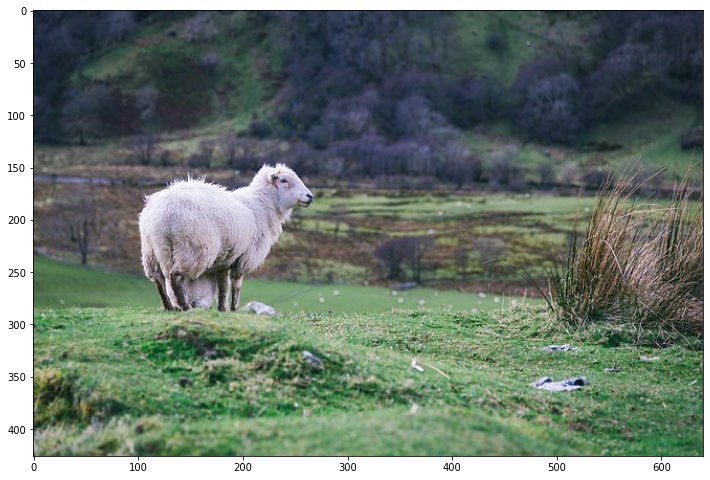

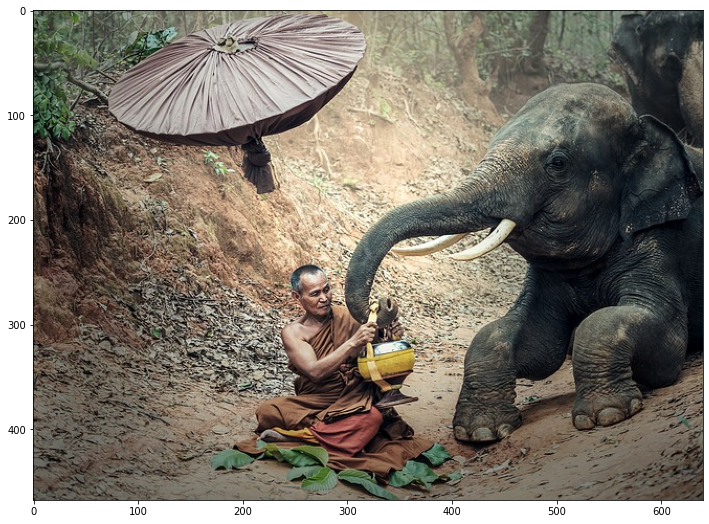

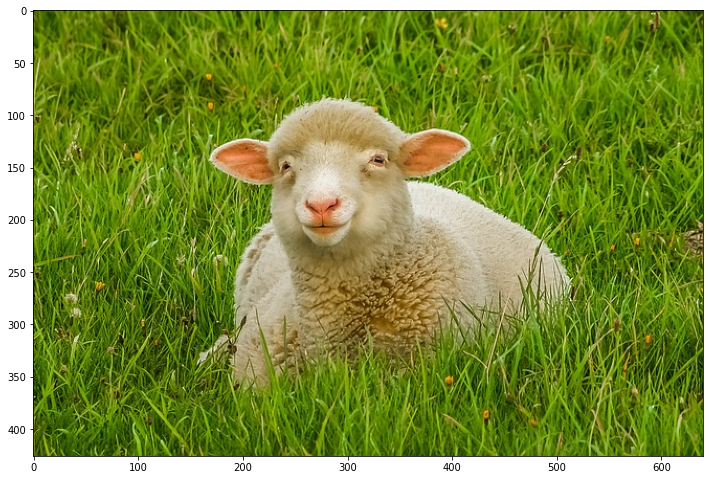

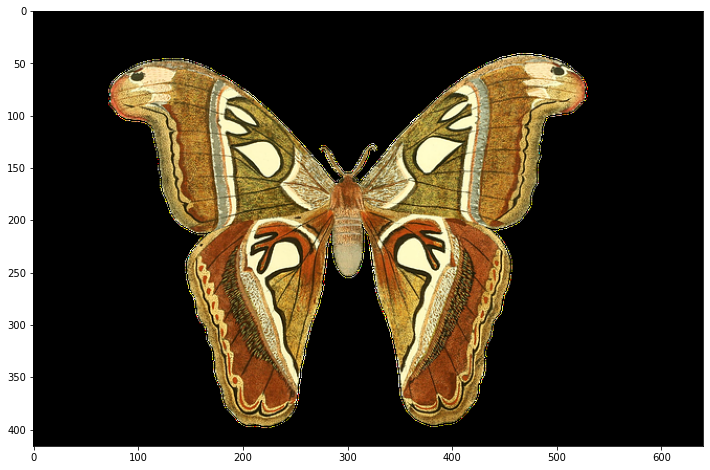

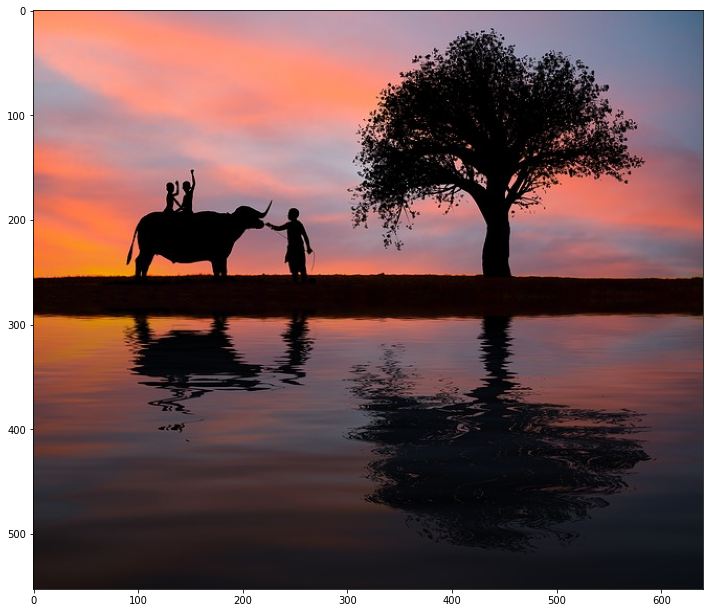

In [21]:
rec_model.test(5)